In [1]:
# !pip install -q requests pandas

from pathlib import Path
import pandas as pd

# === 네 환경에 맞게 여기만 확인/수정 ===
WORKDIR = Path(".")  # 노트북 파일이 있는 폴더라면 그대로 두면 됨
INPUT_CSV = WORKDIR / "weighted_score_above_08_250926.csv"   # 네 최종 데이터셋 파일명
APPID_COL = "appid"                                          # appid 컬럼명
OUTPUT_CSV = WORKDIR / "merged_with_revenue.csv"             # 결과 파일명
CACHE_CSV  = WORKDIR / "steamspy_cache.csv"                  # API 캐시

# SteamSpy 호출 간 딜레이(초). 너무 빠르면 429 뜰 수 있음.
API_DELAY_SEC = 0.4

# price 정보 없을 때 쓸 USD 평균판매가(ASP) 가정
FALLBACK_ASP_USD = 20.0

print(INPUT_CSV.resolve())


C:\Users\user\Downloads\mscd\archive\newcarwling.ipynb\weighted_score_above_08_250926.csv


In [2]:
import time, re, json, requests
from typing import Tuple, Optional, Dict, Any

API_URL = "https://steamspy.com/api.php"

def parse_owners_range(s: Optional[str]) -> Tuple[Optional[int], Optional[int], Optional[int]]:
    """'1,000,000 .. 2,000,000' → (1000000, 2000000, 1500000)"""
    if not s or not isinstance(s, str):
        return (None, None, None)
    parts = re.split(r"\s*\.\.\s*", s.strip())
    try:
        low = int(parts[0].replace(",", "")) if parts[0] else None
    except Exception:
        low = None
    try:
        high = int(parts[1].replace(",", "")) if len(parts) > 1 and parts[1] else None
    except Exception:
        high = None
    mid = None
    if low is not None and high is not None:
        mid = (low + high) // 2
    elif low is not None:
        mid = low
    elif high is not None:
        mid = high
    return (low, high, mid)

def fetch_appdetails(appid: int, session: requests.Session, timeout: float = 20.0) -> Dict[str, Any]:
    r = session.get(API_URL, params={"request": "appdetails", "appid": str(appid)}, timeout=timeout)
    r.raise_for_status()
    data = r.json()
    # 일부 앱은 {}가 오기도 함
    if not isinstance(data, dict):
        data = {}
    return {
        "appid": appid,
        "name": data.get("name"),
        "owners": data.get("owners"),            # 'x .. y' 문자열
        "price": data.get("price"),              # USD cents
        "ccu": data.get("ccu"),
        "raw_json": json.dumps(data, ensure_ascii=False)
    }


In [5]:
# === SteamSpy 매출 병합: VS Code Jupyter (Windows) 한 방 실행 셀 ===
# 필요시: !pip install requests pandas

from pathlib import Path
import pandas as pd
import time, re, json, requests
from typing import Tuple, Optional, Dict, Any

# ---------- 경로/파라미터 (네 환경 고정) ----------
BASEDIR = Path(r"C:\Users\user\Downloads\mscd\archive")  # 프로젝트 루트(스크린샷 경로)
INPUT_CSV  = BASEDIR / "weighted_score_above_08_250926.csv"
OUTPUT_CSV = BASEDIR / "merged_with_revenue.csv"
CACHE_CSV  = BASEDIR / "steamspy_cache.csv"
APPID_COL = "appid"
API_DELAY_SEC = 0.4        # 429 나면 0.6~1.0으로 올려
FALLBACK_ASP_USD = 20.0    # price 없을 때 기본 USD 가격 가정

print(f"[PATH] INPUT:  {INPUT_CSV}")
print(f"[PATH] OUTPUT: {OUTPUT_CSV}")
print(f"[PATH] CACHE:  {CACHE_CSV}")

# ---------- 유틸 ----------
API_URL = "https://steamspy.com/api.php"

def parse_owners_range(s: Optional[str]):
    """'1,000,000 .. 2,000,000' -> (low, high, mid)"""
    if not s or not isinstance(s, str):
        return (None, None, None)
    parts = re.split(r"\s*\.\.\s*", s.strip())
    try:  low  = int(parts[0].replace(",", "")) if parts[0] else None
    except: low = None
    try:  high = int(parts[1].replace(",", "")) if len(parts)>1 and parts[1] else None
    except: high = None
    mid = (low + high)//2 if (low is not None and high is not None) else (low or high)
    return (low, high, mid)

def fetch_appdetails(appid: int, session: requests.Session, timeout: float=20.0) -> Dict[str, Any]:
    r = session.get(API_URL, params={"request":"appdetails","appid":str(appid)}, timeout=timeout)
    r.raise_for_status()
    data = r.json()
    if not isinstance(data, dict): data = {}
    return {
        "appid": appid,
        "name": data.get("name"),
        "owners": data.get("owners"),   # 'x .. y'
        "price": data.get("price"),     # USD cents
        "ccu":   data.get("ccu"),
        "raw_json": json.dumps(data, ensure_ascii=False)
    }

# ---------- 1) 베이스 로드 ----------
base = pd.read_csv(INPUT_CSV, low_memory=False)
if APPID_COL not in base.columns:
    raise ValueError(f"'{APPID_COL}' 컬럼이 {INPUT_CSV.name}에 없음")

# appid 정규화(문자/소수점 꼬임 제거)
base["_appid_norm"] = (
    base[APPID_COL].astype(str).str.replace(r"\.0$", "", regex=True).astype(int)
)
appid_list = base["_appid_norm"].dropna().drop_duplicates().tolist()
print(f"[INFO] unique appids: {len(appid_list):,}")

# ---------- 2) 캐시 ----------
try:
    cache = pd.read_csv(CACHE_CSV, dtype={"appid":"int64"}, low_memory=False)
    cached_ids = set(cache["appid"].astype(int).tolist())
    print(f"[INFO] cache loaded: {len(cache):,} rows")
except Exception:
    cache = pd.DataFrame(columns=["appid","owners","price","ccu","name","raw_json"])
    cached_ids = set()
    print("[INFO] cache not found -> new cache")

# ---------- 3) SteamSpy 조회(캐시 없는 것만) ----------
to_fetch = [aid for aid in appid_list if aid not in cached_ids]
print(f"[INFO] to fetch from API: {len(to_fetch):,}")

sess = requests.Session()
rows = []
for i, aid in enumerate(to_fetch, 1):
    try:
        rows.append(fetch_appdetails(aid, sess))
    except Exception as e:
        print(f"[WARN] appid={aid} fetch fail: {e}")
    time.sleep(API_DELAY_SEC)

if rows:
    new_df = pd.DataFrame(rows)
    cache = pd.concat([cache, new_df], ignore_index=True)
    cache = cache.drop_duplicates(subset=["appid"], keep="last")
    cache.to_csv(CACHE_CSV, index=False, encoding="utf-8")
    print(f"[INFO] cache saved: {len(cache):,} rows")

# ---------- 4) 파싱 & 매출 계산 ----------
parsed = cache.copy()
owners_parsed = parsed["owners"].apply(parse_owners_range)
parsed[["owners_low","owners_high","owners_mid"]] = pd.DataFrame(owners_parsed.tolist(), index=parsed.index)

# price(센트) -> USD, 누락시 FALLBACK
parsed["price_usd"] = pd.to_numeric(parsed["price"], errors="coerce")/100.0
parsed["price_usd"] = parsed["price_usd"].where(parsed["price_usd"].notna(), FALLBACK_ASP_USD)

for col in ["owners_low","owners_mid","owners_high"]:
    parsed[f"rev_{col}_usd"] = pd.to_numeric(parsed[col], errors="coerce") * parsed["price_usd"]

keep_cols = [
    "appid","name","ccu","owners",
    "owners_low","owners_mid","owners_high",
    "price_usd",
    "rev_owners_low_usd","rev_owners_mid_usd","rev_owners_high_usd"
]
slim = parsed[keep_cols].copy()

# ---------- 5) 머지 & 저장 (appid 정리 버전) ----------
out = base.merge(
    slim, 
    left_on="_appid_norm", 
    right_on="appid", 
    how="left"
)

# 원본의 _appid_norm, 오른쪽 appid 중복 → 하나만 남기고 'appid'로 정리
out.drop(columns=["_appid_norm"], inplace=True)
out.rename(columns={"appid": "appid"}, inplace=True)

# 저장
out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
print(f"[DONE] wrote -> {OUTPUT_CSV}")

# 미리보기
print(out[["appid","name","owners","price_usd","rev_owners_mid_usd"]].head(10))


[PATH] INPUT:  C:\Users\user\Downloads\mscd\archive\weighted_score_above_08_250926.csv
[PATH] OUTPUT: C:\Users\user\Downloads\mscd\archive\merged_with_revenue.csv
[PATH] CACHE:  C:\Users\user\Downloads\mscd\archive\steamspy_cache.csv
[INFO] unique appids: 11,576
[INFO] cache loaded: 11,545 rows
[INFO] to fetch from API: 31
[WARN] appid=347600 fetch fail: Expecting value: line 1 column 1 (char 0)
[WARN] appid=660160 fetch fail: Expecting value: line 1 column 1 (char 0)
[WARN] appid=666610 fetch fail: Expecting value: line 1 column 1 (char 0)
[WARN] appid=666820 fetch fail: Expecting value: line 1 column 1 (char 0)
[WARN] appid=704190 fetch fail: Expecting value: line 1 column 1 (char 0)
[INFO] cache saved: 11,571 rows
[DONE] wrote -> C:\Users\user\Downloads\mscd\archive\merged_with_revenue.csv


KeyError: "['appid'] not in index"

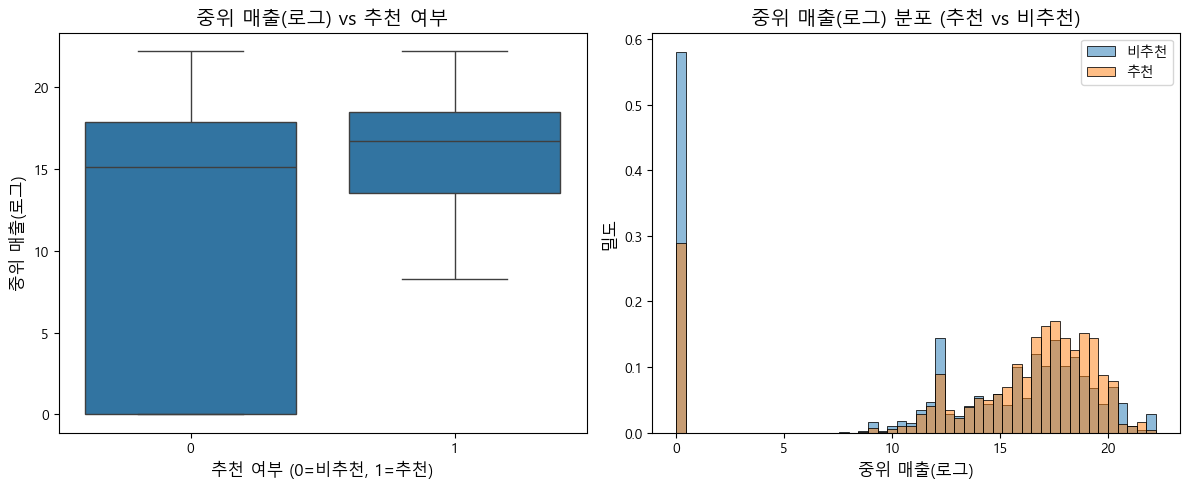

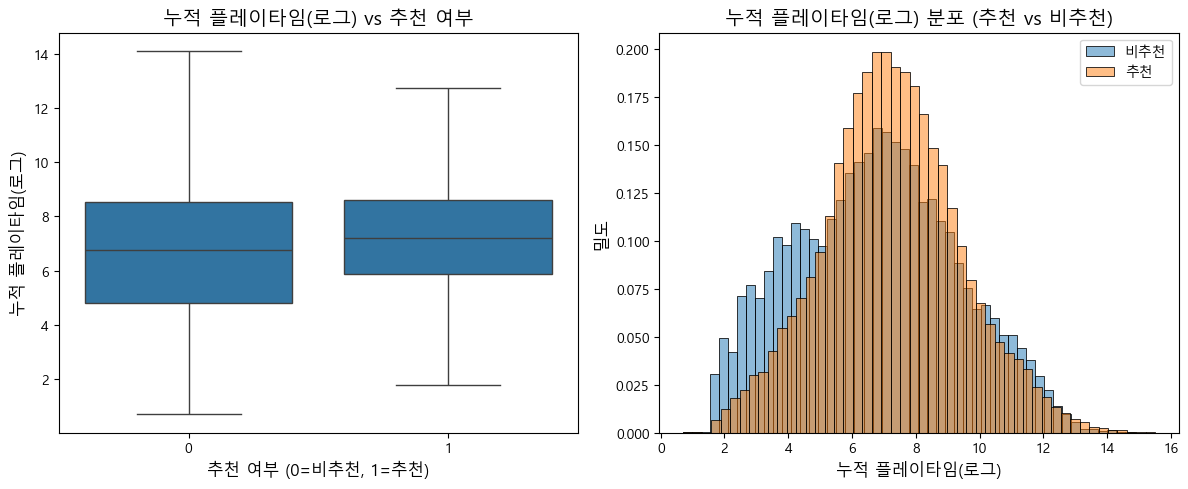

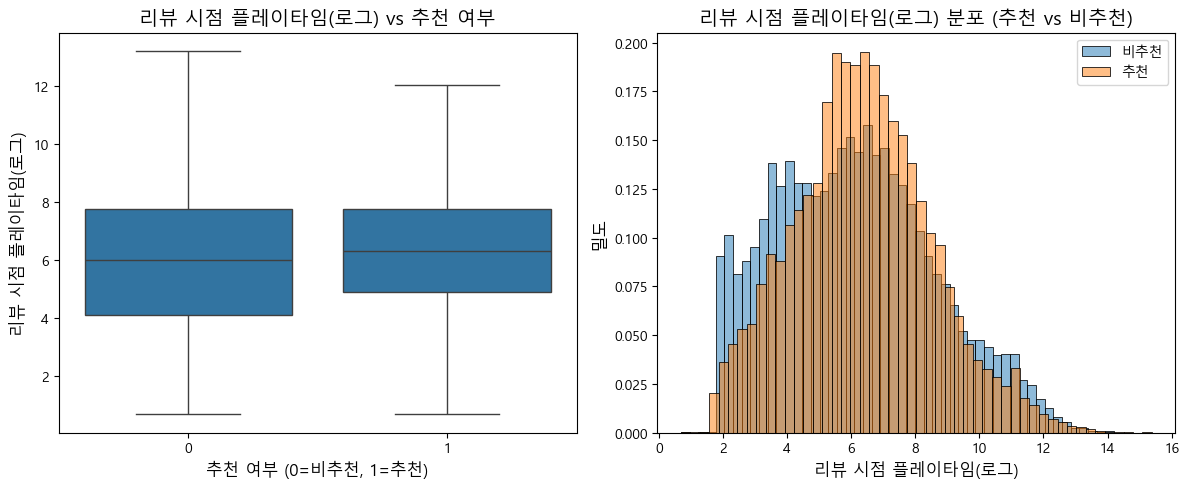

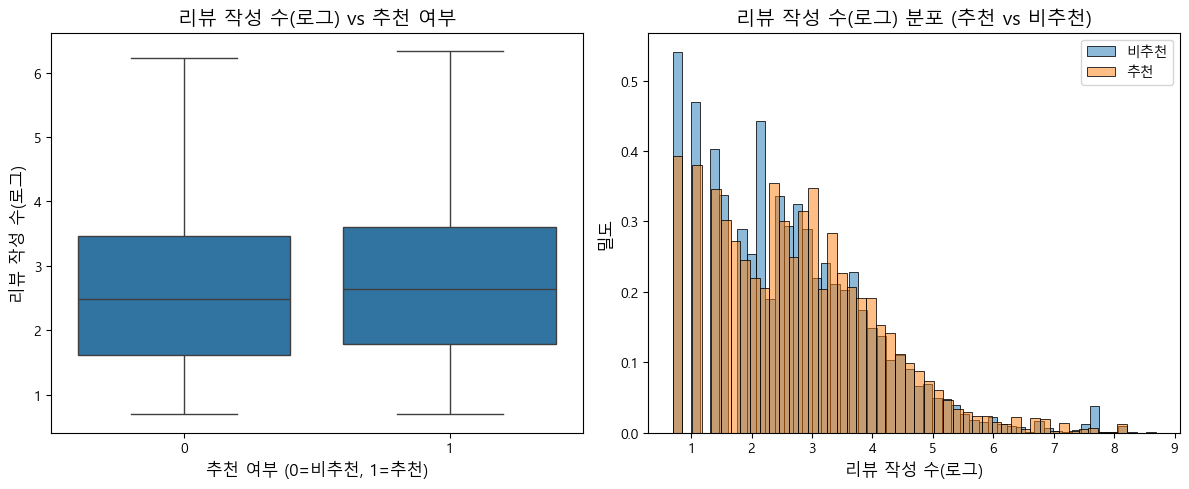

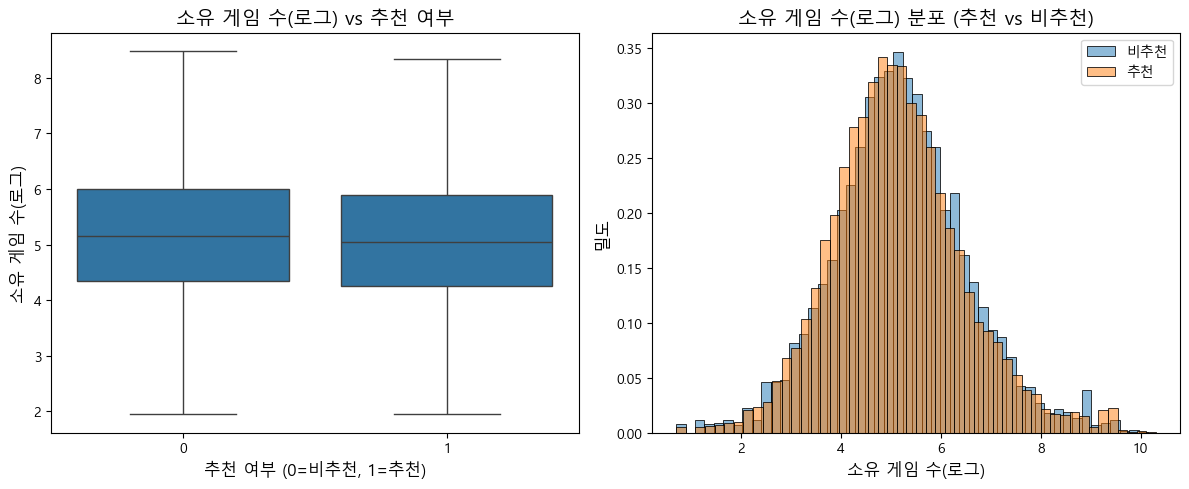

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# ===== 한글 폰트 설정 =====
# 윈도우: 'Malgun Gothic', 맥: 'AppleGothic', 리눅스: 'NanumGothic'
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)  # 마이너스 깨짐 방지

# ===== 데이터 불러오기 =====
df = pd.read_csv("merged_with_revenue.csv", low_memory=False)

# 필요한 칼럼만 변환
cols = ["voted_up","rev_owners_mid_usd",
        "author_playtime_forever","author_playtime_at_review",
        "author_num_reviews","author_num_games_owned"]
df = df[cols].dropna().copy()

# 숫자 변환
for c in cols[1:]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna()

# 로그 변환 추가
df["log1p_rev_mid"] = np.log1p(df["rev_owners_mid_usd"].clip(lower=0))
df["log1p_forever"] = np.log1p(df["author_playtime_forever"].clip(lower=0))
df["log1p_at_review"] = np.log1p(df["author_playtime_at_review"].clip(lower=0))
df["log1p_num_reviews"] = np.log1p(df["author_num_reviews"].clip(lower=0))
df["log1p_num_owned"] = np.log1p(df["author_num_games_owned"].clip(lower=0))

# ===== 시각화 대상 변수들 =====
plot_vars = {
    "log1p_rev_mid": "중위 매출(로그)",
    "log1p_forever": "누적 플레이타임(로그)",
    "log1p_at_review": "리뷰 시점 플레이타임(로그)",
    "log1p_num_reviews": "리뷰 작성 수(로그)",
    "log1p_num_owned": "소유 게임 수(로그)"
}

# ===== 시각화 =====
for col, label in plot_vars.items():
    fig, axes = plt.subplots(1,2, figsize=(12,5))

    # Boxplot
    sns.boxplot(x="voted_up", y=col, data=df, showfliers=False, ax=axes[0])
    axes[0].set_title(f"{label} vs 추천 여부", fontsize=14)
    axes[0].set_xlabel("추천 여부 (0=비추천, 1=추천)", fontsize=12)
    axes[0].set_ylabel(label, fontsize=12)

    # Histogram 분포
    for v in [0,1]:
        sns.histplot(df[df["voted_up"]==v][col], bins=50, alpha=0.5, 
                     stat="density", ax=axes[1], label="추천" if v==1 else "비추천")
    axes[1].legend()
    axes[1].set_title(f"{label} 분포 (추천 vs 비추천)", fontsize=14)
    axes[1].set_xlabel(label, fontsize=12)
    axes[1].set_ylabel("밀도", fontsize=12)

    plt.tight_layout()
    plt.show()


                            OLS Regression Results                            
Dep. Variable:            log_rev_max   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1249.
Date:                Mon, 29 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:43:16   Log-Likelihood:            -6.1581e+05
No. Observations:              188266   AIC:                         1.232e+06
Df Residuals:                  188262   BIC:                         1.232e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.9720      0.079    125.692   

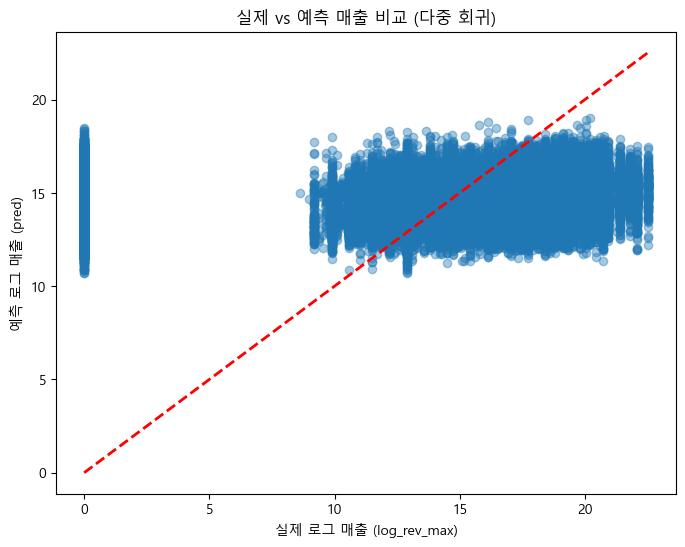

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ===== 한글 폰트 세팅 (윈도우 기준) =====
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ===== 데이터 불러오기 =====
df = pd.read_csv("S-team_250929.csv", low_memory=False)

# 필요한 칼럼만
cols = ["rev_owners_max_usd","author_num_games_owned",
        "author_num_reviews","author_playtime_forever"]
df = df[cols].dropna().copy()

# 로그 변환
df["log_rev_max"] = np.log1p(df["rev_owners_max_usd"])
df["log_owned"] = np.log1p(df["author_num_games_owned"])
df["log_reviews"] = np.log1p(df["author_num_reviews"])
df["log_playtime"] = np.log1p(df["author_playtime_forever"])

# ===== 회귀 분석 =====
X = df[["log_owned","log_reviews","log_playtime"]]
X = sm.add_constant(X)
y = df["log_rev_max"]

model = sm.OLS(y, X).fit()
print(model.summary())

# ===== 예측 =====
df["pred"] = model.predict(X)

# ===== 시각화 =====
plt.figure(figsize=(8,6))
plt.scatter(df["log_rev_max"], df["pred"], alpha=0.4)
plt.plot([df["log_rev_max"].min(), df["log_rev_max"].max()],
         [df["log_rev_max"].min(), df["log_rev_max"].max()],
         color="red", linestyle="--", linewidth=2)

plt.xlabel("실제 로그 매출 (log_rev_max)")
plt.ylabel("예측 로그 매출 (pred)")
plt.title("실제 vs 예측 매출 비교 (다중 회귀)")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ===== 데이터 불러오기 =====
df = pd.read_csv("S-team_250929.csv", low_memory=False)

# 타겟: 매출 (로그 변환)
y = np.log1p(df["rev_owners_max_usd"])

# 피처: 숫자형 변수 전부 사용 (매출 칼럼 제외)
X = df.select_dtypes(include=[np.number]).drop(columns=["rev_owners_max_usd"])

# 결측치 제거
X = X.fillna(0)

# ===== 학습/테스트 분할 =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== 모델 =====
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=-1, random_state=42)
model.fit(X_train, y_train)

# ===== 평가 =====
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# ===== 피처 중요도 =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.DataFrame({"feature": X.columns, "importance": model.feature_importances_})
feat_imp = feat_imp.sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_imp.head(15))
plt.title("LightGBM 피처 중요도 Top 15")
plt.show()
